In [14]:
# import necessary packeges
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper

from collections import OrderedDict

from sklearn.model_selection import cross_val_score, train_test_split

from torch.utils.data.sampler import SubsetRandomSampler

import time

Get the device. Device is either cuda:0 or cpu

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
# define a trandform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

# download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data', train=True, download=True, transform=transform)
#train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# download and load the testing data
testset = datasets.FashionMNIST('F_MNIST_data', train=False, download=True, transform=transform)
#test_loader = DataLoader(testset, batch_size=64, shuffle=True)
print(trainset)
print(testset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: F_MNIST_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: F_MNIST_data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None


In [17]:
shuffle_dataset = True
validation_split = .2
random_seed= 42

trainset_size = len(trainset)
indices = list(range(trainset_size))
split = int(np.floor(validation_split * trainset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices))
print(len(val_indices))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


48000
12000


In [18]:
train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
validation_loader = DataLoader(trainset, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

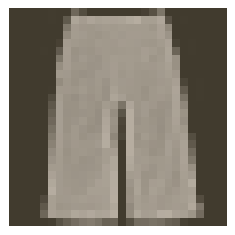

In [19]:
images, labels = next(iter(train_loader))
helper.imshow(images[0,:]);

In [20]:
images.size()

torch.Size([64, 1, 28, 28])

In [21]:
labels.size()

torch.Size([64])

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits from the forward pass. It's up to you how many layers you add and the size of those layers.

In [22]:
input_layer = 784
hidden_layers = [8000, 6000, 4000, 200]
output_layer = 10

netmodel = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(input_layer, hidden_layers[0])),
    ('relu1', nn.ReLU()),
    ('fcl2', nn.Linear(hidden_layers[0], hidden_layers[0])),
    ('relu2', nn.ReLU()),
    ('fcl3', nn.Linear(hidden_layers[0], hidden_layers[1])),
    ('relu3', nn.ReLU()),
    ('fcl4', nn.Linear(hidden_layers[1], hidden_layers[1])),
    ('relu4', nn.ReLU()),
    ('fcl5', nn.Linear(hidden_layers[1], hidden_layers[2])),
    ('relu5', nn.ReLU()),
    ('fcl6', nn.Linear(hidden_layers[2], hidden_layers[2])),
    ('relu6', nn.ReLU()),
    ('fcl7', nn.Linear(hidden_layers[2], hidden_layers[3])),
    ('relu7', nn.ReLU()),
    ('fcl8', nn.Linear(hidden_layers[3], hidden_layers[3])),
    ('relu8', nn.ReLU()),
    ('output', nn.Linear(hidden_layers[3], output_layer))
]))

netmodel

Sequential(
  (fcl1): Linear(in_features=784, out_features=8000, bias=True)
  (relu1): ReLU()
  (fcl2): Linear(in_features=8000, out_features=8000, bias=True)
  (relu2): ReLU()
  (fcl3): Linear(in_features=8000, out_features=6000, bias=True)
  (relu3): ReLU()
  (fcl4): Linear(in_features=6000, out_features=6000, bias=True)
  (relu4): ReLU()
  (fcl5): Linear(in_features=6000, out_features=4000, bias=True)
  (relu5): ReLU()
  (fcl6): Linear(in_features=4000, out_features=4000, bias=True)
  (relu6): ReLU()
  (fcl7): Linear(in_features=4000, out_features=200, bias=True)
  (relu7): ReLU()
  (fcl8): Linear(in_features=200, out_features=200, bias=True)
  (relu8): ReLU()
  (output): Linear(in_features=200, out_features=10, bias=True)
)

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [23]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(netmodel.parameters(), lr=0.001)
optimizer = optim.Adam(netmodel.parameters(), lr=0.0003)
#optimizer = optim.SGD(netmodel.parameters(), lr=0.003)

In [24]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40

netmodel.to(device)

start = time.time()

for e in range(epochs):
    running_loss = 0
    for images, labels in iter(train_loader):
        steps += 1
        
        # flatten the imiga into a 784 element vector
        images.resize_(images.size()[0], 784)
        
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        output = netmodel.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            netmodel.eval()
        
            accuracy = 0
            valid_loss = 0
            
            for ii, (images, labels) in enumerate(validation_loader):
                
                
                # flatten the imiga into a 784 element vector
                images.resize_(images.size()[0], 784)
                
                with torch.no_grad():
                    images, labels = images.to(device), labels.to(device)

                output = netmodel.forward(images)
                valid_loss += criterion(output, labels).item()
                
                ps = F.softmax(output, dim=1)
                
                equality = (labels.data == ps.max(1)[1])
                
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(validation_loader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            netmodel.train()
            
print("Time for training and validation : {:.0f} minutes and {:.3f} seconds".format((time.time() - start)/60, (time.time() - start) % 60))

Epoch: 1/2...  Loss: 1.8158 Validation Loss: 1.564..  Validation Accuracy: 0.303


KeyboardInterrupt: 

In [ ]:
netmodel.eval()

netmodel.to(device)
        
accuracy = 0
test_loss = 0

for ii, (images, labels) in enumerate(test_loader):


    # flatten the imiga into a 784 element vector
    images.resize_(images.size()[0], 784)

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)

    output = netmodel.forward(images)

    ps = F.softmax(output, dim=1)

    equality = (labels.data == ps.max(1)[1])

    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

running_loss = 0

In [ ]:
# Test out your network!
netmodel.to('cpu')

dataiter = iter(test_loader)
images, labels = dataiter.next()

img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilities (softmax) for img
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = netmodel.forward(img)
    
ps = F.softmax(logits, dim=1)
print(ps.size())
print(ps.max(1)[1])

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')